**Author:** Beatrice Occhiena s314971. See [`LICENSE`](https://github.com/beatrice-occhiena/Computational_intelligence/blob/main/LICENSE) for details.
- institutional email: `S314971@studenti.polito.it`
- personal email: `beatrice.occhiena@live.it`
- github repository: [https://github.com/beatrice-occhiena/Computational_intelligence.git](https://github.com/beatrice-occhiena/Computational_intelligence.git)

**Resources:** These notes are the result of additional research and analysis of the lecture material presented by Professor Giovanni Squillero for the Computational Intelligence course during the academic year 2023-2024 @ Politecnico di Torino. They are intended to be my attempt to make a personal contribution and to rework the topics covered in the following resources.
- [https://github.com/squillero/computational-intelligence](https://github.com/squillero/computational-intelligence)
- Stuart Russel, Peter Norvig, *Artificial Intelligence: A Modern Approach* [3th edition]
- Sean Luke, *Essentials of Metaheuristics* [2nd edition]

.

.

# LAB9
Write a local-search algorithm (eg. an EA) able to solve the Problem instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

## Black-box optimization
In this lab, we will explore the use of local-search algorithms to solve **black-box optimization problems**. In this kind of problems, the details of the fitness function remain concealed to the algorithm, which can only evaluate candidate solutions by calling the function itself.

> ❗ The algorithm must be able to probe the fitness landscape, and find a good solution, yet devoid of any information regarding the inner workings or mathematical properties of the function.



### Abstract problem definition
The provided code in [lab9_lib.py](https://github.com/beatrice-occhiena/Computational_intelligence/blob/main/Labs/Lab_09/lab9_lib.py) establishes the problem space through the `AbstractProblem` class, offering a framework for defining problem instances with varying genome length.

In [1]:
from random import choices, random, randint
import lab9_lib as abstract_problem
import matplotlib.pyplot as plt

In [3]:
fitness = abstract_problem.make_problem(5)
for n in range(10):
    ind = choices([0, 1], k=50)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

11110100001101110000101011010101010101100111001111: 12.67%
10010001100010100001010001101010110011110011011011: 12.91%
01111011101101000011101011111001000000100100111100: 12.69%
11100101110000111010100000010101101101111000000101: 35.34%
11010000111110011001101010111100010100101000010001: 12.89%
01000000011110000011110101001111111100100001110010: 12.69%
11011001011111110111000000101111101101111011010000: 26.67%
11111111111110101111101011110011110010000001010111: 14.45%
01110111110110010000110101111110011000100111000011: 14.69%
11010010101000010111101000111011111111010010001111: 12.67%
10


## Individual representation

I considered an individual as a list of binary values, where each value represents a locus of the genome. The length of the list is equal to the number of loci of the genome.

Depending on the problem instance, the number of genes considered for the fitness evaluation is different.

In [4]:
class Individual:
    
    def __init__(self, num_loci: int):
        self.num_loci = num_loci
        self.genome = choices([0, 1], k=num_loci)
        self.fitness = None

    def __str__(self):
        return f"Fitness: {self.fitness:.2%}"
    
    def __repr__(self):
        return str(self)
    
    def show(self):
        """Show the genome as a grayscale image and print the fitness."""
        plt.figure(figsize=(20, 20))
        plt.imshow([self.genome], cmap="Greys", aspect=10)
        plt.yticks([])
        plt.xticks([i*100 for i in range(self.num_loci//100+1)])
        plt.title(f"Fitness: {self.fitness:.2%}")
        plt.show()

    def compute_fitness(self, fitness_function):
        self.fitness = fitness_function(self.genome)

    
    

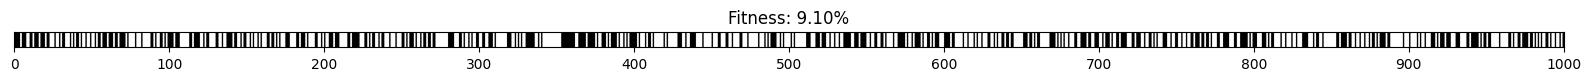

In [5]:
ind = Individual(1000)
ind.compute_fitness(fitness)
ind.show()

### Population functions

In [17]:
def make_population(pop_size: int, num_loci: int, fitness_function):

    """Make a population of individuals with unique genomes."""
    population = []     # list of individuals
    hash_table = {}     # hash table to keep track of unique individuals

    # 1. Initialize the new population
    while len(population) < pop_size:

        # 1.1. Generate a new random individual
        ind = Individual(num_loci)
        
        # 1.2. Only if its genome is unique
        if tuple(ind.genome) not in hash_table:

            # 1.2.1 Compute the fitness of the individual
            ind.compute_fitness(fitness_function)
            # 1.2.2 Add the genome to the hash table
            hash_table[tuple(ind.genome)] = ind.fitness
            # 1.2.3 Add the individual to the population
            population.append(ind)

    return population, hash_table


def update_population(population: list, offspring: list, population_size: int):
    """Keep only the best individuals between the population and the offspring."""
    combined_population = population + offspring
    combined_population.sort(key=lambda ind: ind.fitness, reverse=True)
    return combined_population[:population_size]


def find_best(population: list):
    """Find the individual with the highest fitness."""
    return max(population, key=lambda ind: ind.fitness)


def find_worst(population: list):
    """Find the individual with the lowest fitness."""
    return min(population, key=lambda ind: ind.fitness)

### Selection functions

In [7]:
def select_parent(population: list, tournament_size: int):
    """Select a parent using tournament selection."""
    tournament = choices(population, k=tournament_size)
    return find_best(tournament)

### Crossover functions

In [8]:
def uniform_xover(parent1: Individual, parent2: Individual):
    """Perform uniform crossover on two parents."""

    # 1. Create a new dummy child
    child = Individual(parent1.num_loci)
    child.fitness = min(parent1.fitness, parent2.fitness)

    # 2. For each locus
    for i in range(child.num_loci):
        # 2.1 Choose randomly from either parent
        child.genome[i] = choices([parent1.genome[i], parent2.genome[i]])[0]

    return child


def one_cut_xover(parent1: Individual, parent2: Individual):
    """Perform one-cut crossover on two parents."""

    # 1. Create a new dummy child
    child = Individual(parent1.num_loci)    
    child.fitness = min(parent1.fitness, parent2.fitness)

    # 2. Choose a random crossover point
    cut = randint(1, child.num_loci-1)

    # 3. Copy the first part from parent 1
    child.genome[:cut] = parent1.genome[:cut]

    # 4. Copy the second part from parent 2
    child.genome[cut:] = parent2.genome[cut:]

    return child


def gene_cut_xover(parent1: Individual, parent2: Individual, num_genes: int):
    """Perform one-cut crossover on each gene of two parents."""

    # 1. Create a new dummy child
    child = Individual(parent1.num_loci)
    child.fitness = min(parent1.fitness, parent2.fitness)

    # 2. Compute the length of each gene
    gene_len = child.num_loci // num_genes

    # 3. For each gene
    for i in range(num_genes):
        # 3.1 Choose a random crossover point
        cut = randint(i*gene_len, (i+1)*gene_len-1)

        # 3.2 Copy the first part from parent 1
        child.genome[i*gene_len:cut] = parent1.genome[i*gene_len:cut]

        # 3.3 Copy the second part from parent 2
        child.genome[cut:(i+1)*gene_len] = parent2.genome[cut:(i+1)*gene_len]

    return child

### Mutation functions

In [9]:
def mutate_locus(ind: Individual, mutation_rate: float):
  """
    Mutate a single locus in a gene of an individual's genome to create a new individual.
    - The mutation rate is based on the fitness of the individual.
  """
 
  # 1. Select the locus to mutate
  locus = randint(0, ind.num_loci-1)

  # 2. Mutate the locus with the given mutation rate
  if random() < mutation_rate:
    ind.genome[locus] = 1 - ind.genome[locus]


def mutate_gene(ind: Individual, num_genes: int, mutation_rate: float):

  """
    Mutate all the loci of an individual's gene to create a new individual.
    - The mutation rate is based on the fitness of the individual.
  """
 
  # 1. Select the gene to mutate
  gene = randint(0, num_genes-1)
  gene_len = ind.num_loci // num_genes

  # 2. For each locus in the gene
  for i in range(gene*gene_len, (gene+1)*gene_len):
    # 2.1. Mutate the locus with the given mutation rate
    if random() < mutation_rate:
      ind.genome[i] = 1 - ind.genome[i]


def mutate_all(ind: Individual, mutation_rate: float):
  """
    Mutate all the loci of an individual's genome to create a new individual.
    - The mutation rate is based on the fitness of the individual.
  """
 
  # 1. For each locus in the genome
  for i in range(ind.num_loci):
    # 1.1. Mutate the locus with the given mutation rate
    if random() < mutation_rate:
      ind.genome[i] = 1 - ind.genome[i]

In [10]:
PROBLEM_INSTANCES = [1, 2, 5, 10]
NUM_LOCI = 1000

## Problem instance 1

### Hill Climbing

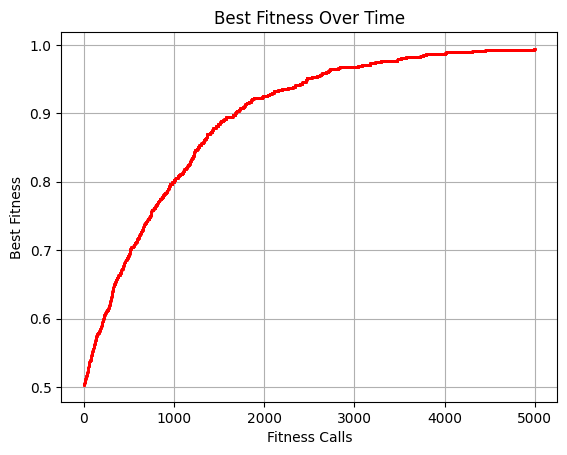

BEST INDIVIDUAL


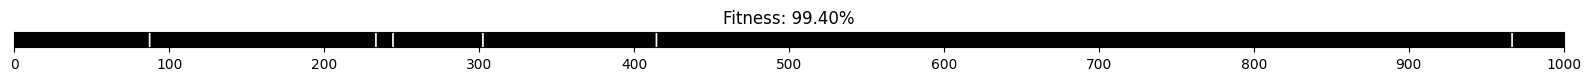

Fitness function calls: 5000


In [154]:
PROBLEM_INSTANCE = 1
fitness_function = abstract_problem.make_problem(PROBLEM_INSTANCE)

# 0. Set up the plot
plt.title("Best Fitness Over Time")
plt.xlabel("Fitness Calls")
plt.ylabel("Best Fitness")
plt.grid(True)

# 1. Create the dictionary of tested individuals
tested_individuals = {}

# 2. Create the initial individual
individual = Individual(NUM_LOCI)
individual.compute_fitness(fitness_function)
tested_individuals[tuple(individual.genome)] = individual.fitness

# 3. Run the hill climber
while fitness_function.calls < 5000:
    
    # 3.1. Make a copy of the individual
    new_individual = Individual(NUM_LOCI)
    new_individual.genome = individual.genome.copy()

    # 3.2. Mutate the copy
    mutate_all(new_individual, 0.0001)

    # 3.3. Compute the fitness of the mutated copy only if it was not tested before
    if tuple(new_individual.genome) not in tested_individuals:
        new_individual.compute_fitness(fitness_function)
        tested_individuals[tuple(new_individual.genome)] = new_individual.fitness
        plt.plot(fitness_function.calls, individual.fitness, "ro", markersize=1)
    else:
        new_individual.fitness = tested_individuals[tuple(new_individual.genome)]

    # 3.4. Replace the old individual with the new one if it is better
    if new_individual.fitness > individual.fitness:
        individual = new_individual

# 4. Show the best individual
plt.show()
print("BEST INDIVIDUAL")
individual.show()
print(f"Fitness function calls: {fitness_function.calls}")

## Problem instance 2

### Hill Climbing

INITIAL INDIVIDUAL


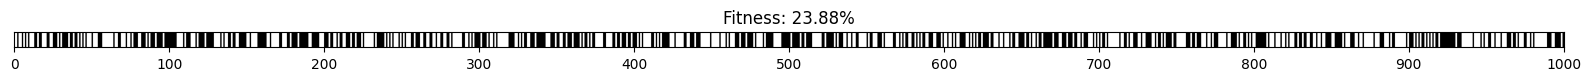

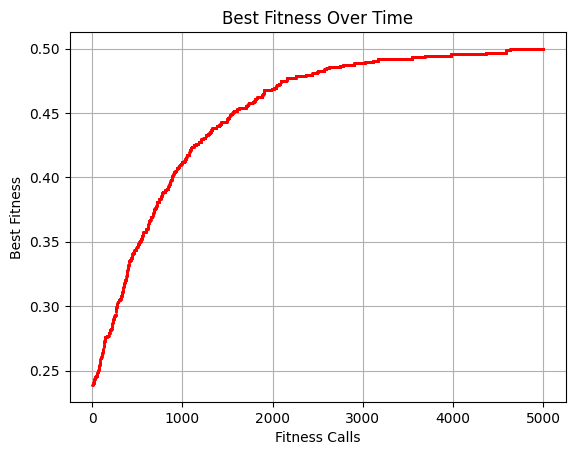

BEST INDIVIDUAL


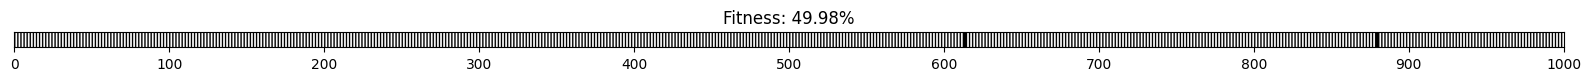

Fitness function calls: 5000


In [155]:
PROBLEM_INSTANCE = 2
fitness_function = abstract_problem.make_problem(PROBLEM_INSTANCE)

# 0. Create the dictionary of tested individuals
tested_individuals = {}

# 1. Create the initial individual
individual = Individual(NUM_LOCI)
individual.compute_fitness(fitness_function)
tested_individuals[tuple(individual.genome)] = individual.fitness

print("INITIAL INDIVIDUAL")
individual.show()

# 2. Set up the plot
plt.title("Best Fitness Over Time")
plt.xlabel("Fitness Calls")
plt.ylabel("Best Fitness")
plt.grid(True)

# 3. Run the hill climber
while fitness_function.calls < 5000:
    
    # 3.1. Make a copy of the individual
    new_individual = Individual(NUM_LOCI)
    new_individual.genome = individual.genome.copy()

    # 3.2. Mutate the copy
    mutate_all(new_individual, 0.0001)

    # 3.3. Compute the fitness of the mutated copy only if it was not tested before
    if tuple(new_individual.genome) not in tested_individuals:
        new_individual.compute_fitness(fitness_function)
        tested_individuals[tuple(new_individual.genome)] = new_individual.fitness
        plt.plot(fitness_function.calls, individual.fitness, "ro", markersize=1)
    else:
        new_individual.fitness = tested_individuals[tuple(new_individual.genome)]

    # 3.4. Replace the old individual with the new one if it is better
    if new_individual.fitness > individual.fitness:
        individual = new_individual

# 4. Show the best individual
plt.show()
print("BEST INDIVIDUAL")
individual.show()
print(f"Fitness function calls: {fitness_function.calls}")

### Evolutionary Algorithm

Best_iniz: 24.23%
Best_prima_0: 24.23%
Best_prima_1: 23.43%
Best_prima_2: 23.43%
Best_prima_3: 23.43%
Best_prima_4: 23.43%
Best_prima_5: 23.43%
Best_prima_6: 23.43%
Best_prima_7: 23.43%
Best_prima_8: 23.43%
Best_prima_9: 23.43%
Best_prima_10: 23.43%
Best_prima_11: 23.43%
Best_prima_12: 23.43%
Best_prima_13: 23.43%
Best_prima_14: 23.43%
Best_prima: 23.43%
Best_dopo: 51.00%
Best_iniz: 51.00%
Best_prima_0: 51.00%
Best_prima_1: 51.00%
Best_prima_2: 51.00%
Best_prima_3: 51.00%
Best_prima_4: 51.00%
Best_prima_5: 51.00%
Best_prima_6: 51.00%
Best_prima_7: 51.00%
Best_prima_8: 51.00%
Best_prima_9: 51.00%
Best_prima_10: 51.00%
Best_prima_11: 51.00%
Best_prima_12: 51.00%
Best_prima_13: 51.00%
Best_prima_14: 22.87%
Best_prima: 22.87%
Best_dopo: 25.93%
Best_iniz: 25.93%
Best_prima_0: 25.93%
Best_prima_1: 25.93%
Best_prima_2: 25.93%
Best_prima_3: 25.93%
Best_prima_4: 25.93%
Best_prima_5: 25.93%
Best_prima_6: 25.93%
Best_prima_7: 25.93%
Best_prima_8: 25.93%
Best_prima_9: 24.40%
Best_prima_10: 24.40%


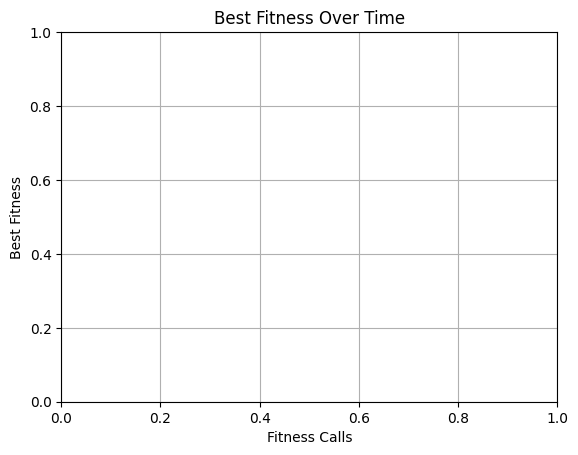

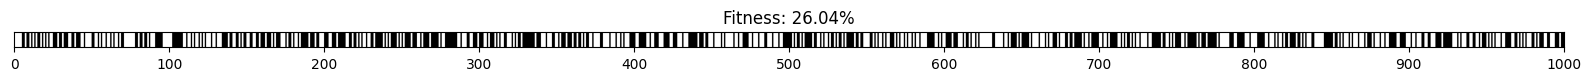

Fitness function calls: 4510


In [18]:
POPULATION_SIZE = 10
OFFSPRING_SIZE = 15
NUM_GENERATIONS = 300
mutation_rate = 0.15
crossover_rate = 0.8
tournament_size = 5

PROBLEM_INSTANCE = 2
fitness_function = abstract_problem.make_problem(PROBLEM_INSTANCE)

# 0. Set up the plot
plt.title("Best Fitness Over Time")
plt.xlabel("Fitness Calls")
plt.ylabel("Best Fitness")
plt.grid(True)

# 1. Create the initial population
individuals, tested_individuals = make_population(POPULATION_SIZE, NUM_LOCI, fitness_function)
best_individual =  find_best(individuals)

# 2. Run the evolutionary algorithm
for generation in range(NUM_GENERATIONS): # ADD UNCHANGED AFTER A BIT

    # 2.1. Create the offspring population
    offspring = []

    # Print individuals
    print(f"Best_iniz: {best_individual.fitness:.2%}")

    # 2.2. Create the offspring population
    for i in range(OFFSPRING_SIZE):
        # 2.2.1. Select two parents
        parent1 = select_parent(individuals, tournament_size)
        parent2 = select_parent(individuals, tournament_size)

        # 2.2.2. Perform crossover
        if random() < crossover_rate:
            child = uniform_xover(parent1, parent2)
        else:
            child = parent1

        # 2.2.3. Mutate the child
        mutate_all(child, mutation_rate)

        # 2.2.4. If the child is unique
        if tuple(child.genome) not in tested_individuals:
            
            # 2.2.4.1. Compute its fitness and add it to the list of tested individuals
            child.compute_fitness(fitness_function)
            tested_individuals[tuple(child.genome)] = child.fitness
            offspring.append(child)

        else:
            # 2.2.4.2. Discard the child
            i -= 1

        # Print individuals
        print(f"Best_prima_{i}: {best_individual.fitness:.2%}")

    # Print individuals
    print(f"Best_prima: {best_individual.fitness:.2%}")
        
    # 2.3. Replace the old population with the offspring population
    individuals = update_population(individuals, offspring, POPULATION_SIZE)

    # 2.4. Find the best individual
    best_individual = find_best(individuals)
     # Print individuals
    print(f"Best_dopo: {best_individual.fitness:.2%}")
    #plt.plot(fitness_function.calls, best_individual.fitness, "ro", markersize=1)

# 3. Show the best individual
plt.show()
best_individual.show()
print(f"Fitness function calls: {fitness_function.calls}")

## Problem instance 5

INITIAL INDIVIDUAL


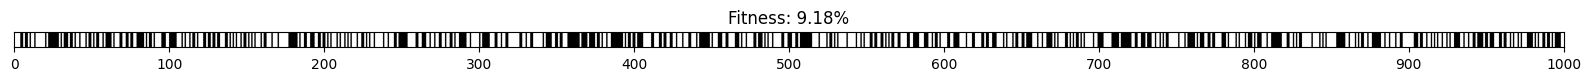

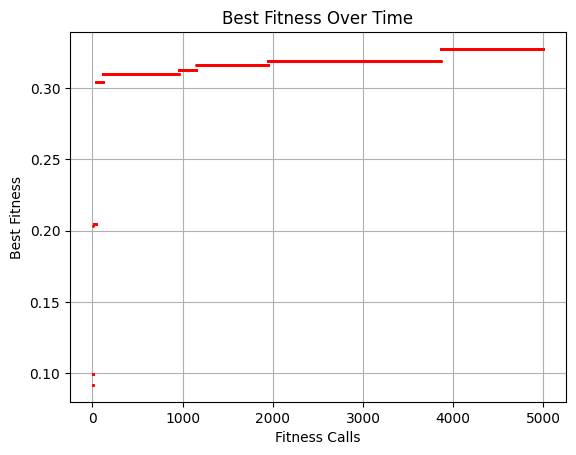

BEST INDIVIDUAL


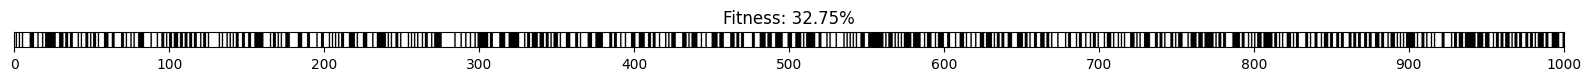

Fitness function calls: 5000


In [157]:
PROBLEM_INSTANCE = 5
fitness_function = abstract_problem.make_problem(PROBLEM_INSTANCE)

# 0. Create the dictionary of tested individuals
tested_individuals = {}

# 1. Create the initial individual
individual = Individual(NUM_LOCI)
individual.compute_fitness(fitness_function)
tested_individuals[tuple(individual.genome)] = individual.fitness

print("INITIAL INDIVIDUAL")
individual.show()

# 2. Set up the plot
plt.title("Best Fitness Over Time")
plt.xlabel("Fitness Calls")
plt.ylabel("Best Fitness")
plt.grid(True)

# 3. Run the hill climber
while fitness_function.calls < 5000:
    
    # 3.1. Make a copy of the individual
    new_individual = Individual(NUM_LOCI)
    new_individual.genome = individual.genome.copy()

    # 3.2. Mutate the copy
    mutate_all(new_individual, 0.15)

    # 3.3. Compute the fitness of the mutated copy only if it was not tested before
    if tuple(new_individual.genome) not in tested_individuals:
        new_individual.compute_fitness(fitness_function)
        tested_individuals[tuple(new_individual.genome)] = new_individual.fitness
        plt.plot(fitness_function.calls, individual.fitness, "ro", markersize=1)
    else:
        new_individual.fitness = tested_individuals[tuple(new_individual.genome)]

    # 3.4. Replace the old individual with the new one if it is better
    if new_individual.fitness > individual.fitness:
        individual = new_individual

# 4. Show the best individual
plt.show()
print("BEST INDIVIDUAL")
individual.show()
print(f"Fitness function calls: {fitness_function.calls}")

## Problem instance 10

INITIAL INDIVIDUAL


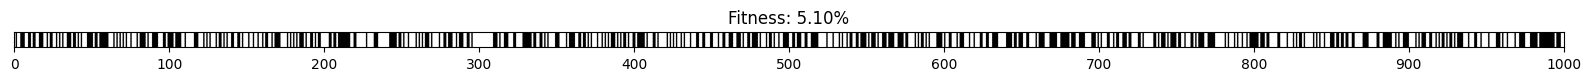

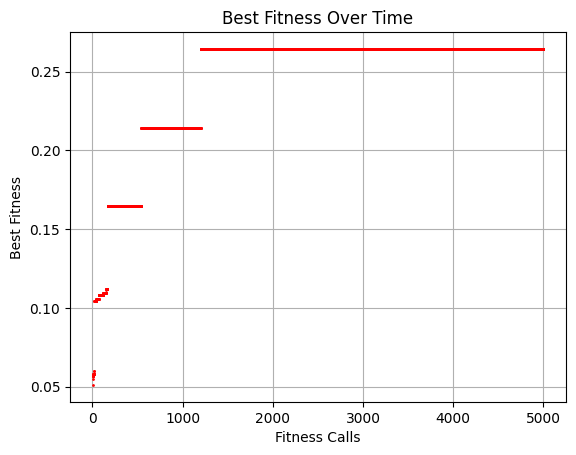

BEST INDIVIDUAL


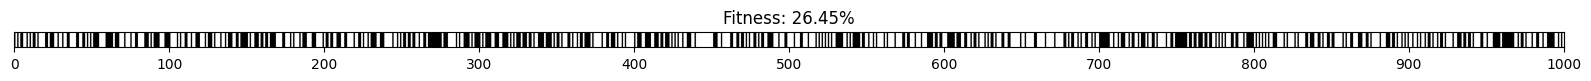

Fitness function calls: 5000


In [158]:
PROBLEM_INSTANCE = 10
fitness_function = abstract_problem.make_problem(PROBLEM_INSTANCE)

# 0. Create the dictionary of tested individuals
tested_individuals = {}

# 1. Create the initial individual
individual = Individual(NUM_LOCI)
individual.compute_fitness(fitness_function)
tested_individuals[tuple(individual.genome)] = individual.fitness

print("INITIAL INDIVIDUAL")
individual.show()

# 2. Set up the plot
plt.title("Best Fitness Over Time")
plt.xlabel("Fitness Calls")
plt.ylabel("Best Fitness")
plt.grid(True)

# 3. Run the hill climber
while fitness_function.calls < 5000:
    
    # 3.1. Make a copy of the individual
    new_individual = Individual(NUM_LOCI)
    new_individual.genome = individual.genome.copy()

    # 3.2. Mutate the copy
    mutate_all(new_individual, 0.5)

    # 3.3. Compute the fitness of the mutated copy only if it was not tested before
    if tuple(new_individual.genome) not in tested_individuals:
        new_individual.compute_fitness(fitness_function)
        tested_individuals[tuple(new_individual.genome)] = new_individual.fitness
        plt.plot(fitness_function.calls, individual.fitness, "ro", markersize=1)
    else:
        new_individual.fitness = tested_individuals[tuple(new_individual.genome)]

    # 3.4. Replace the old individual with the new one if it is better
    if new_individual.fitness > individual.fitness:
        individual = new_individual

# 4. Show the best individual
plt.show()
print("BEST INDIVIDUAL")
individual.show()
print(f"Fitness function calls: {fitness_function.calls}")